# Pokemon winner prediction

Goal: to predict which Pokemon will win the fight

## This notebook splits into 3 parts

```
1. Data preparation
2. Analyze / visualize data, to find insight
3. Model
- 3.1 Create train data
- 3.2 Perform model & evaluation
- 3.3 Model summary
```

In [135]:
import sys
import os.path
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
plt.style.use('ggplot')
seed = 1
np.random.seed(seed)
print(sys.version)
print(matplotlib.__version__)

3.6.5 (v3.6.5:f59c0932b4, Mar 28 2018, 16:07:46) [MSC v.1900 32 bit (Intel)]
2.2.2


In [136]:
def line():
    print("\n----------------------------------------------------------------\n")

In [137]:
pokemon_df = pd.read_csv('./input/pokemon.csv')
combat_df = pd.read_csv('./input/combats.csv')

In [138]:
print('pokemon_df')
display(pokemon_df.head())
display(pokemon_df.describe())
display(pokemon_df.shape)
pokemon_df.info()
line()

print('combat_df')
display(combat_df.head())
display(combat_df.describe())
display(combat_df.shape)
combat_df.info()

pokemon_df


,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


,#,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
count,800.0000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000
mean,400.5000,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500,3.32375
std,231.0844,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474,1.66129
min,1.0000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.00000
25%,200.7500,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000,2.00000
50%,400.5000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.00000
75%,600.2500,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.00000
max,800.0000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000,6.00000


(800, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 12 columns):
#             800 non-null int64
Name          799 non-null object
Type 1        800 non-null object
Type 2        414 non-null object
HP            800 non-null int64
Attack        800 non-null int64
Defense       800 non-null int64
Sp. Atk       800 non-null int64
Sp. Def       800 non-null int64
Speed         800 non-null int64
Generation    800 non-null int64
Legendary     800 non-null bool
dtypes: bool(1), int64(8), object(3)
memory usage: 60.2+ KB

----------------------------------------------------------------

combat_df


,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151


,First_pokemon,Second_pokemon,Winner
count,50000.000000,50000.000000,50000.000000
mean,400.495640,403.159660,408.890100
std,229.549429,230.083644,231.159961
min,1.000000,1.000000,1.000000
25%,203.000000,207.000000,206.000000
50%,399.000000,402.000000,422.000000
75%,597.250000,602.000000,606.000000
max,800.000000,800.000000,800.000000


(50000, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
First_pokemon     50000 non-null int64
Second_pokemon    50000 non-null int64
Winner            50000 non-null int64
dtypes: int64(3)
memory usage: 1.1 MB


## 1. Data preparation

In [139]:
"""
1.1 Replace missing data

from point 1.1 we saw 1 row that have missing name, we'll fill it
@see https://bulbapedia.bulbagarden.net/wiki/List_of_Pok%C3%A9mon_by_National_Pok%C3%A9dex_number
"""

display(pokemon_df.loc[pokemon_df['Name'].isnull()==True])
name = 'Primeape'
pokemon_df.loc[62, 'Name'] = name
display(pokemon_df[pokemon_df['Name']==name])

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
62,63,NaN,Fighting,NaN,65,105,60,60,70,95,1,False


,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
62,63,Primeape,Fighting,NaN,65,105,60,60,70,95,1,False


In [140]:
"""
1.2 Rename columns
"""

pokemon_df.columns = ['#', 'name', 'type1', 'type2', 'hp', 'atk', 'def', 'sp.atk', 'sp.def', 'speed', 'generation', 'legendary']
combat_df.columns = ['first', 'second', 'winner']

display(pokemon_df.head())
display(combat_df.head())

,#,name,type1,type2,hp,atk,def,sp.atk,sp.def,speed,generation,legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


,first,second,winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151


In [141]:
"""
1.3 Create new attrs
"""

# pokemon
# - total, total stat attr
pokemon_df['total'] = pokemon_df['hp'] + pokemon_df['atk'] + pokemon_df['def'] + \
    pokemon_df['sp.atk'] + pokemon_df['sp.def'] + pokemon_df['speed']

# combat
# - loser, Pokemon loser id
# - is_first_win, boolean
# - diff_stat, between first Pokemon and second
no_total_dict = dict(zip(pokemon_df['#'], pokemon_df['total']))
cols = ['first', 'second', 'winner']
combat_stat_df = combat_df[cols].replace(no_total_dict)
combat_df['loser'] = combat_df.apply(lambda x: x['first'] if x['first'] !=  x['winner'] else x['second'], axis=1)
combat_df['is_first_win'] = combat_df['first'] == combat_df['winner']
combat_df['diff_stat'] = combat_stat_df['first'] - combat_stat_df['second']

print('pokemon')
display(pokemon_df.head())
line()

print('combat')
display(combat_stat_df.head())
display(combat_df.head())

pokemon


,#,name,type1,type2,hp,atk,def,sp.atk,sp.def,speed,generation,legendary,total
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False,318
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False,405
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False,525
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False,625
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False,309



----------------------------------------------------------------

combat


,first,second,winner
0,300,340,340
1,580,580,580
2,405,485,485
3,250,485,485
4,495,505,495


,first,second,winner,loser,is_first_win,diff_stat
0,266,298,298,266,False,-40
1,702,701,701,702,False,0
2,191,668,668,191,False,-80
3,237,683,683,237,False,-235
4,151,231,151,231,True,-10


In [142]:
"""
1.4 Create new DataFrame (fight_df)
"""

# fight_df
nfirsts = combat_df['first'].value_counts()
nseconds = combat_df['second'].value_counts()
nfights = nfirsts + nseconds
fight_df = pd.DataFrame({
    'nfights': nfights,
    'nwins': combat_df['winner'].value_counts()
}, columns=['nfights', 'nwins'])
fight_df['win_ratio'] = fight_df['nwins'] / fight_df['nfights']
fight_df = fight_df.sort_values(by='win_ratio')

print('fight_df example, data structure')
display(fight_df.head())
fight_df.info()
line()

print('fight_df example, check missing / incorrect data')
display(fight_df.loc[fight_df['win_ratio'].isnull() | (fight_df['win_ratio'] > 1)])
line()

print('fight_df, fill missing data with 0')
fight_df.loc[231, ['nfights', 'nwins', 'win_ratio']] = 0
display(fight_df.tail())

fight_df example, data structure


,nfights,nwins,win_ratio
290,138,3.0,0.021739
190,122,3.0,0.024590
639,129,4.0,0.031008
237,123,4.0,0.032520
577,128,5.0,0.039062


<class 'pandas.core.frame.DataFrame'>
Int64Index: 784 entries, 290 to 231
Data columns (total 3 columns):
nfights      784 non-null int64
nwins        783 non-null float64
win_ratio    783 non-null float64
dtypes: float64(2), int64(1)
memory usage: 24.5 KB

----------------------------------------------------------------

fight_df example, check missing / incorrect data


,nfights,nwins,win_ratio
231,135,NaN,NaN



----------------------------------------------------------------

fight_df, fill missing data with 0


,nfights,nwins,win_ratio
20,119,115.0,0.966387
704,125,121.0,0.968000
513,119,116.0,0.974790
155,129,127.0,0.984496
231,0,0.0,0.000000


In [143]:
"""
1.xxxx
"""

'\n1.xxxx\n'

## 2. Analyze / visualize data

Number of top 5 percent: 40


,#,name,type1,type2,hp,atk,def,sp.atk,sp.def,speed,generation,legendary,total
426,427,Mega Rayquaza,Dragon,Flying,105,180,100,180,100,115,3,True,780
164,165,Mega Mewtwo Y,Psychic,NaN,106,150,70,194,120,140,1,True,780
163,164,Mega Mewtwo X,Psychic,Fighting,106,190,100,154,100,130,1,True,780
422,423,Primal Kyogre,Water,NaN,100,150,90,180,160,90,3,True,770
424,425,Primal Groudon,Ground,Fire,100,180,160,150,90,90,3,True,770


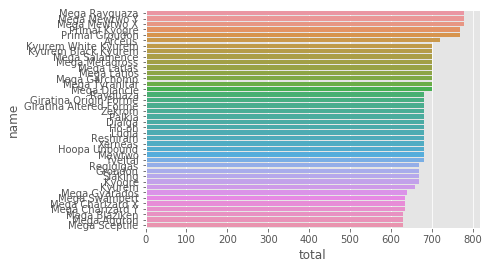

In [144]:
"""
2.1 Top 5 percent of high-stats Pokemon
"""

# top 5
n_top5_percent = round(0.05 * pokemon_df.shape[0])
top_five_df = pokemon_df.sort_values(['total'], ascending=False)[:n_top5_percent]

# print and plot
print('Number of top 5 percent: %d' % n_top5_percent)
plt.figure()
sns.barplot(x='total', y='name', data=top_five_df, estimator=sum)
top_five_df.head()

In [145]:
"""
2.2 In top 5 percent of highest-stats, how many legendary in there ?
"""

legendary_df = pokemon_df.loc[pokemon_df['legendary'] == True]
n_legendary = legendary_df.shape[0]

top5_legendary_df = top_five_df.loc[top_five_df['legendary'] == True]
n_top5_legendary = top5_legendary_df.shape[0]

print('Top highest stats')
print('Number of top 5%:', n_top5_percent)
print('Number of legendary in top 5%%: %d' % n_top5_legendary)
print('Percentage of legendary in top 5%%: %.2f %%' % (n_top5_legendary * 100 / n_top5_percent))

Top highest stats
Number of top 5%: 40
Number of legendary in top 5%: 28
Percentage of legendary in top 5%: 70.00 %


C:\Python36-32\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


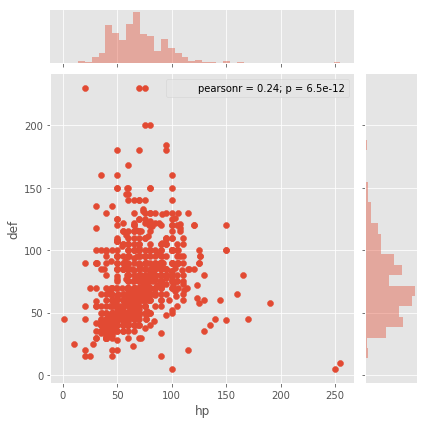

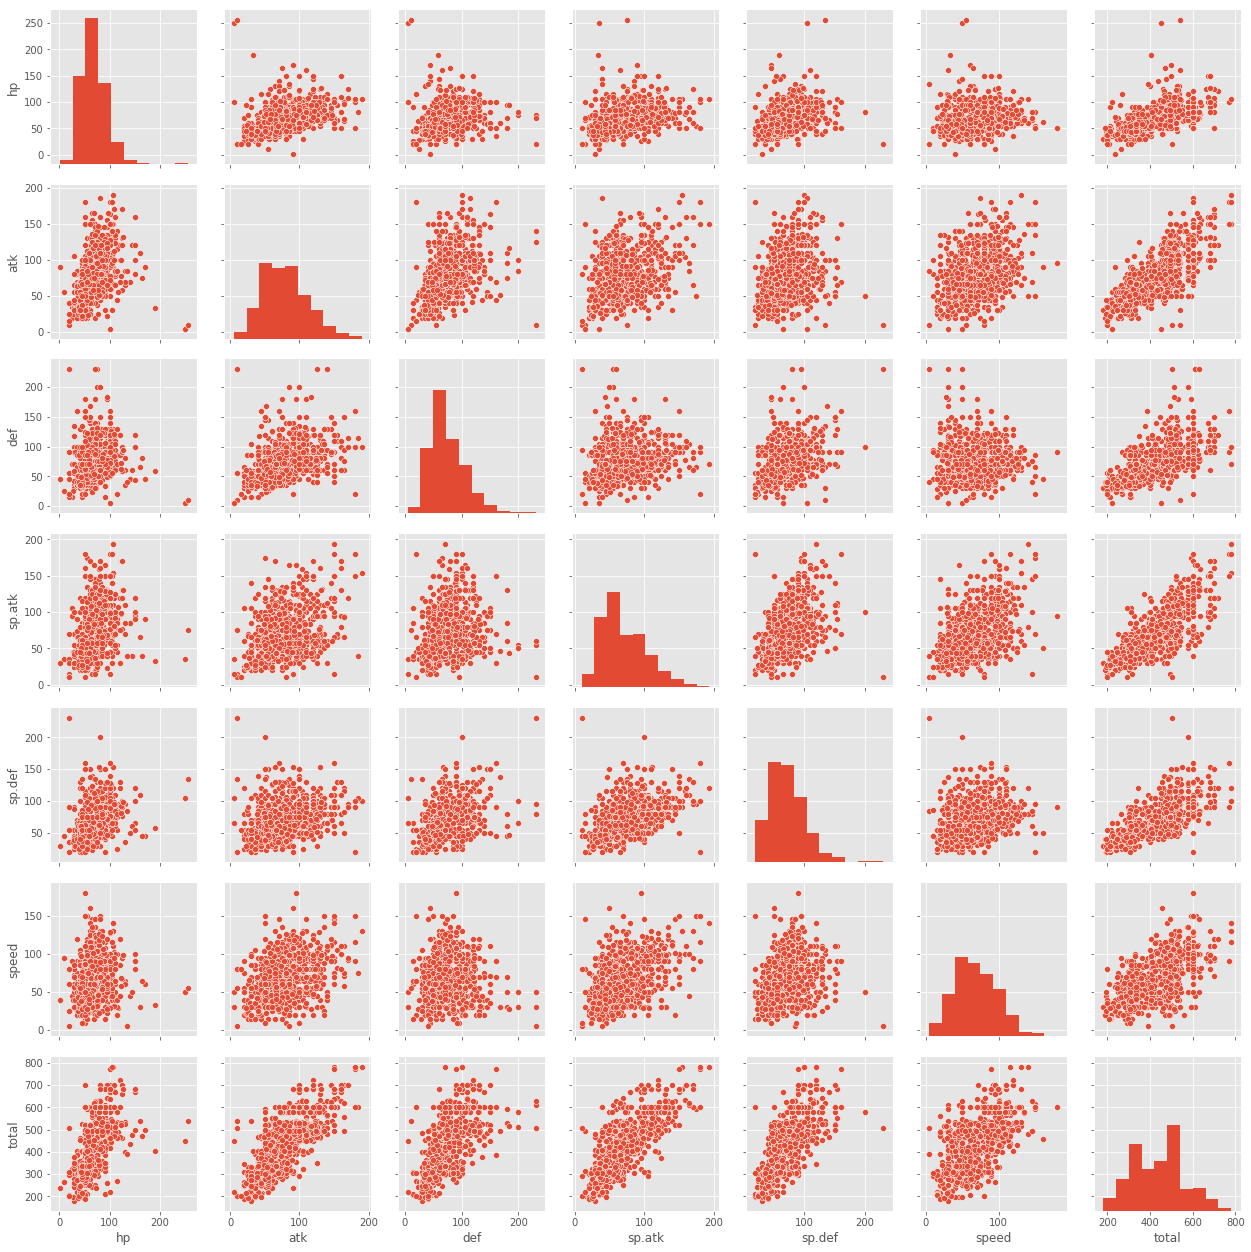

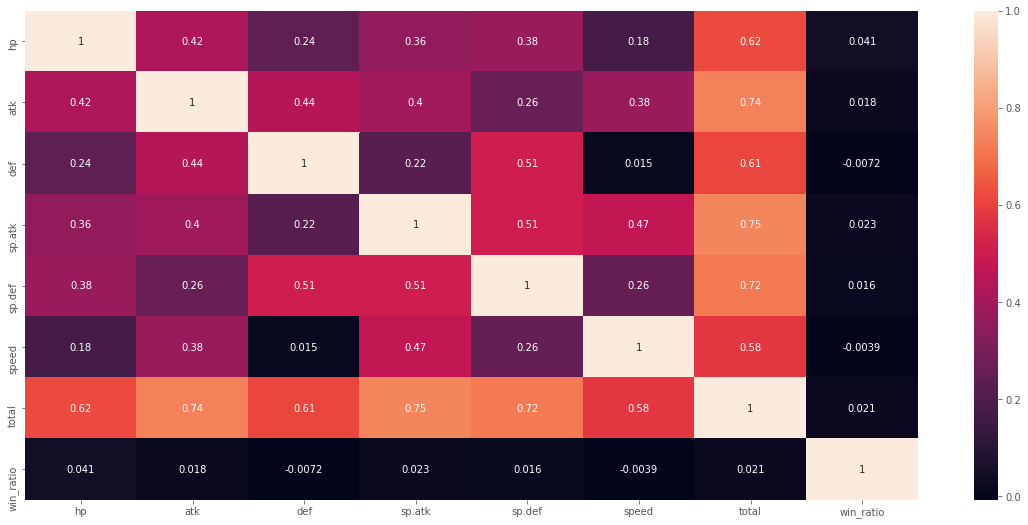

In [146]:
"""
2.3 Attribute distribution & correlation, pokemon that have high def-stat, also have high hp-stat ?
"""

drop_columns = ['#', 'name', 'type1', 'type2', 'generation', 'legendary']

 # hp vs def
sns.jointplot(x='hp', y='def', data=pokemon_df)

 # eacho
sns.pairplot(pokemon_df.drop(drop_columns, 1))

# corr
plt.figure(figsize=(20, 9))
sns.heatmap(pokemon_fight_df.drop(drop_columns, 1).corr(), annot=True)
plt.show()

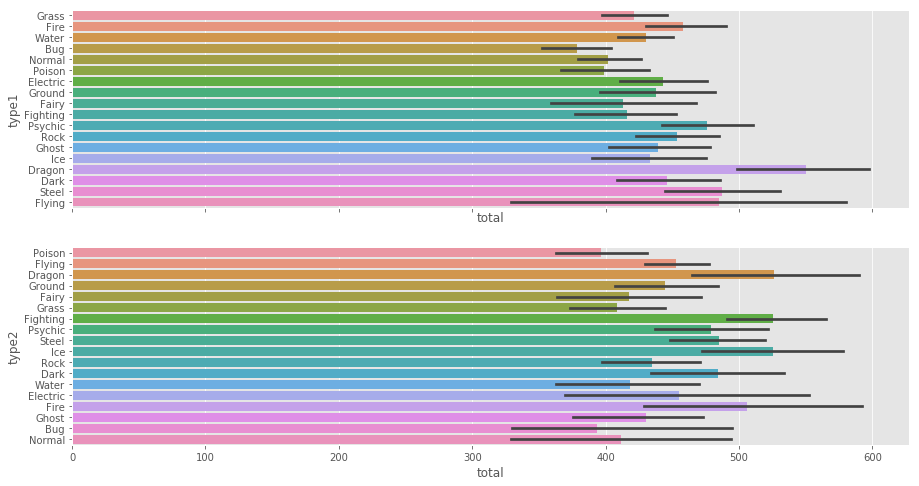

In [147]:
"""
2.4 Most powerful type of pokemon based on type
"""

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
sns.barplot(x='total', y='type1', data=pokemon_df, ax=ax1)
sns.barplot(x='total', y='type2', data=pokemon_df, ax=ax2)

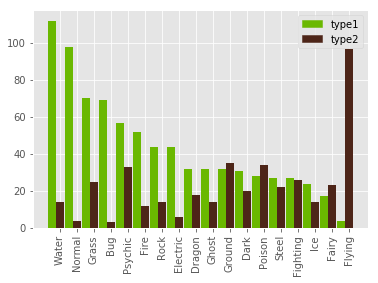

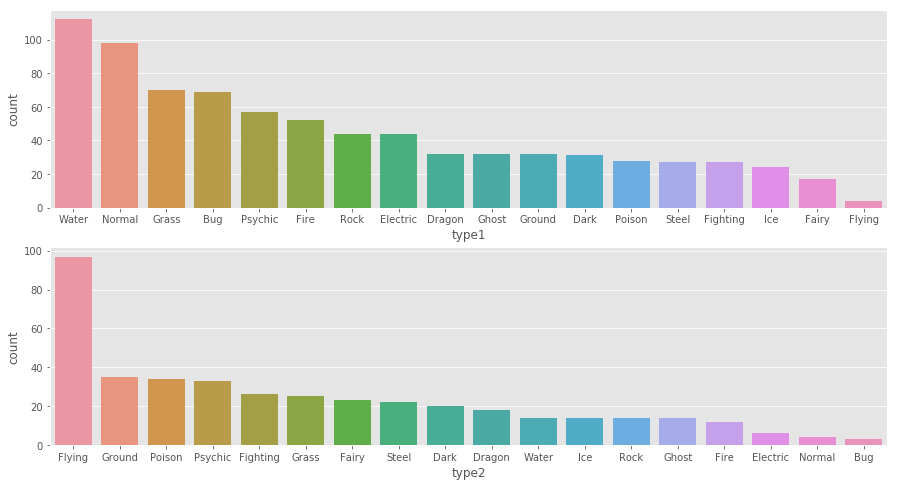

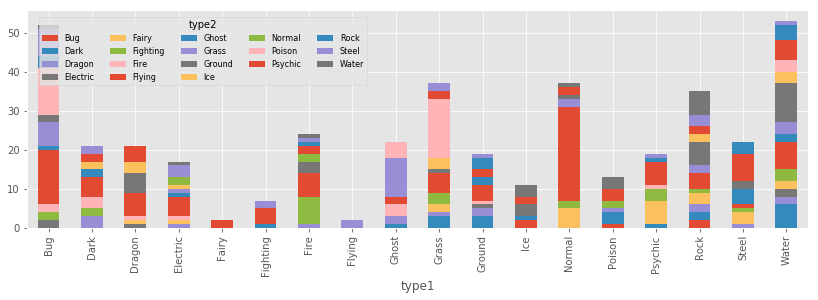

In [148]:
"""
2.5 Number of Pokemon for each type
"""

# type1 and typ2 in same graph
frame = pokemon_df.copy()
vals1 = [frame['type1'].value_counts()[key] for key in frame['type1'].value_counts().index]
vals2 = [frame['type2'].value_counts()[key] for key in frame['type1'].value_counts().index]
inds = np.arange(len(frame['type1'].value_counts().index))
width = .45
color1 = np.random.rand(3)
color2 = np.random.rand(3)
handles = [patches.Patch(color=color1, label='type1'), patches.Patch(color=color2, label='type2')]
plt.bar(inds, vals1, width, color=color1)
plt.bar(inds + width, vals2, width, color=color2)
plt.gca().set_xticklabels(frame['type1'].value_counts().index)
plt.gca().set_xticks(inds + width)
plt.xticks(rotation=90)
plt.legend(handles=handles)

# type1 and type2
f, ax = plt.subplots(2, 1, figsize=(15, 8))
sns.countplot('type1', data=pokemon_df, ax=ax[0], order=pokemon_df['type1'].value_counts().index)
sns.countplot('type2', data=pokemon_df, ax=ax[1], order=pokemon_df['type2'].value_counts().index)

# type1 and type2 (crosstab)
# pokemon_df['type2'] = pokemon_df['type2'].fillna("None")
type_cross = pd.crosstab(pokemon_df['type1'], pokemon_df['type2'])
type_cross.plot.bar(stacked=True, figsize=(14, 4))
plt.legend(bbox_to_anchor=(0.01, 0.99), loc='upper left', ncol=5, fontsize=8, title='type2')
plt.show()

stats Index(['hp', 'atk', 'def', 'sp.atk', 'sp.def', 'speed', 'generation', 'total'], dtype='object')


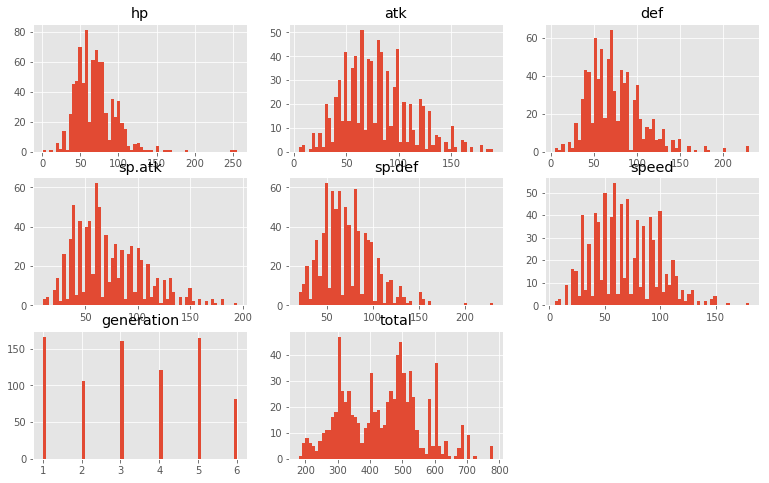

"total" attr
count    800.00000
mean     435.10250
std      119.96304
min      180.00000
25%      330.00000
50%      450.00000
75%      515.00000
max      780.00000
Name: total, dtype: float64


C:\Python36-32\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


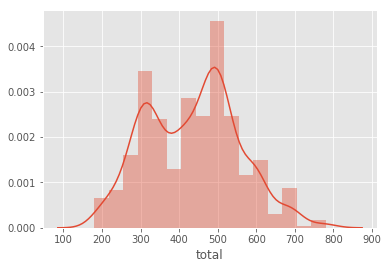

In [149]:
"""
2.6 Stats distribution
"""

stats = pokemon_df.dtypes[pokemon_df.dtypes=='int64'].index
stats = stats[1:]
fig = plt.figure(figsize=(13, 8))
for i, stat in enumerate(stats):
    fig.add_subplot(3, 3, i + 1)
    plt.hist(pokemon_df[stat], bins=60)
    plt.title(stat)

print('stats', stats)
plt.show()

# only "total"
print('"total" attr')
print(pokemon_df['total'].describe())
sns.distplot(pokemon_df['total'])

types ['Grass' 'Fire' 'Water' 'Bug' 'Normal' 'Poison' 'Electric' 'Ground'
 'Fairy' 'Fighting' 'Psychic' 'Rock' 'Ghost' 'Ice' 'Dragon' 'Dark' 'Steel'
 'Flying']
stats Index(['hp', 'atk', 'def', 'sp.atk', 'sp.def', 'speed', 'generation', 'total'], dtype='object')


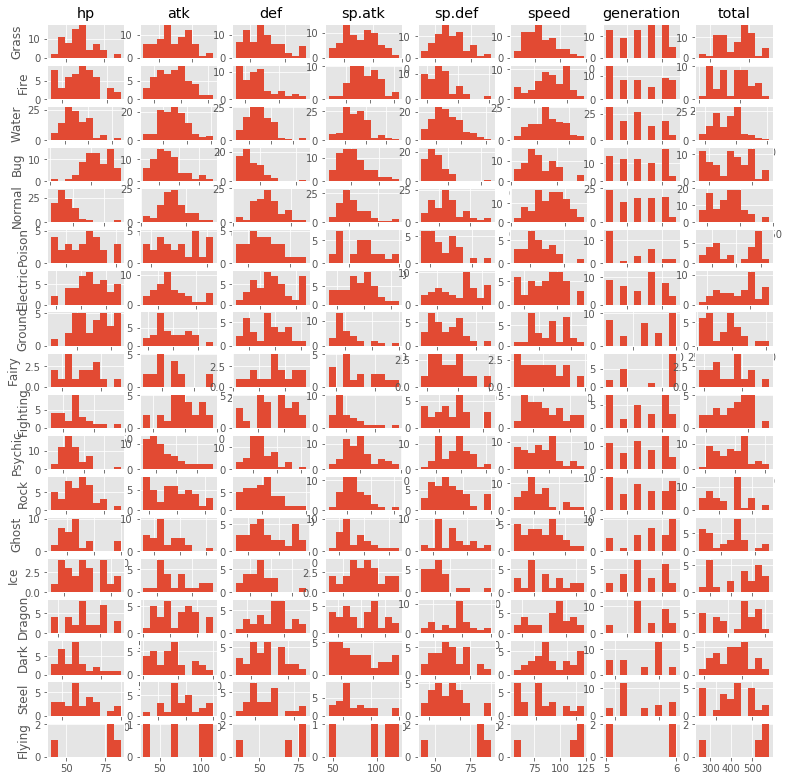

In [150]:
"""
2.7 Stats distribution (per each type1)
"""

types = pokemon_df['type1'].unique()
stats = pokemon_df.dtypes[pokemon_df.dtypes=='int64'].index
stats = stats[1:]
fig = plt.figure(figsize=(13, 15))
for j, typ in enumerate(types):
    for i, stat in enumerate(stats):
        fig.add_subplot(20, 8, (j * 8) + i + 1)
        tmp_df = pokemon_df[pokemon_df['type1']==typ]
        plt.hist(tmp_df[stat], bins=10)
        if (((j * 8) + i) % 8 == 0):
            plt.ylabel(typ)
        if (j == 0):
            plt.title(stat)

print('types', types)
print('stats', stats)
plt.show()

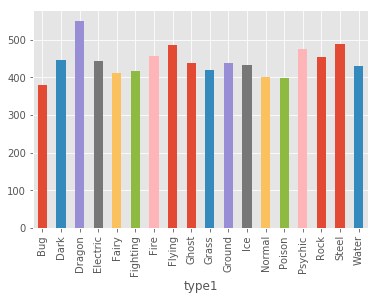

In [151]:
"""
2.8 Average stat per each type1
"""

tmp_df = pokemon_df.groupby(['type1'])['total'].mean()
tmp_df.plot(kind='bar')

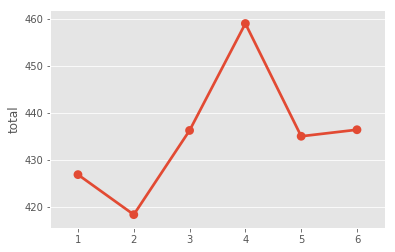

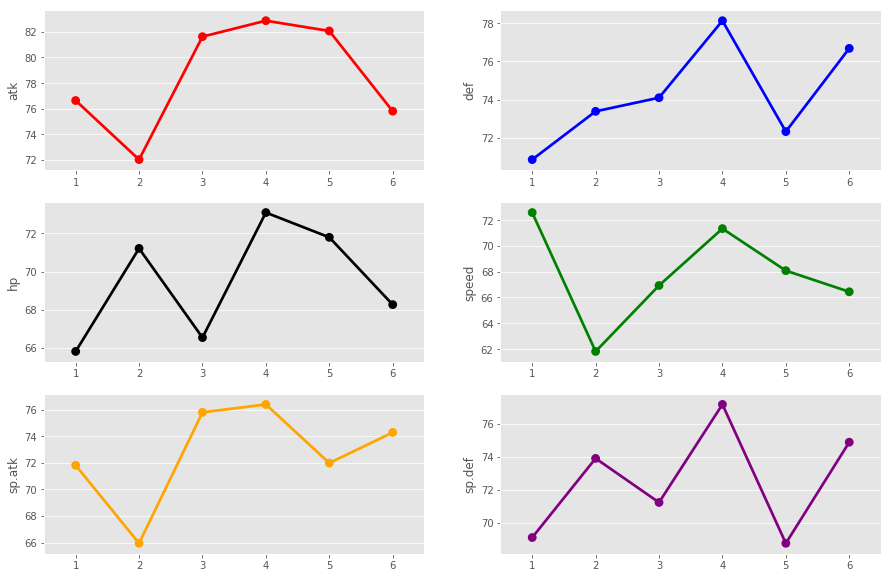

In [152]:
"""
2.9 Average stat per each generation
"""

pokemon_groups = pokemon_df.groupby('generation')
pokemon_groups_mean = pokemon_groups.mean()

# total
sns.pointplot(x=pokemon_groups_mean.index.values, y=pokemon_groups_mean['total'])

# other stats
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(15, 10))
sns.pointplot(x=pokemon_groups_mean.index.values, y=pokemon_groups_mean['atk'], color='red', ax=axes[0][0])
sns.pointplot(x=pokemon_groups_mean.index.values, y=pokemon_groups_mean['def'], color='blue', ax=axes[0][1])
sns.pointplot(x=pokemon_groups_mean.index.values, y=pokemon_groups_mean['hp'], color='black', ax=axes[1][0])
sns.pointplot(x=pokemon_groups_mean.index.values, y=pokemon_groups_mean['speed'], color='green', ax=axes[1][1])
sns.pointplot(x=pokemon_groups_mean.index.values, y=pokemon_groups_mean['sp.atk'], color='orange', ax=axes[2][0])
sns.pointplot(x=pokemon_groups_mean.index.values, y=pokemon_groups_mean['sp.def'], color='purple', ax=axes[2][1])

In [153]:
# todo move
# merged, fight_df into pokemon_df to new pokemon_fight_df
fight_df['#'] = fight_df.index
pokemon_fight_df = pokemon_df.copy()
win_ratio_dict = dict(zip(fight_df['#'], fight_df['win_ratio']))
pokemon_fight_df['win_ratio'] = pokemon_fight_df['#'].replace(win_ratio_dict)
display(pokemon_fight_df.head())

# check Pokemon that have no fight
no_fight_pokemon_df = pokemon_fight_df.loc[(pokemon_fight_df['win_ratio'] > 1) | pokemon_fight_df['win_ratio'].isnull()]
print('Pokemon that have no fight: %d' % no_fight_pokemon_df.shape[0])
display(no_fight_pokemon_df)

,#,name,type1,type2,hp,atk,def,sp.atk,sp.def,speed,generation,legendary,total,win_ratio
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False,318,0.278195
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False,405,0.380165
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False,525,0.674242
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False,625,0.560000
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False,309,0.491071


Pokemon that have no fight: 16


,#,name,type1,type2,hp,atk,def,sp.atk,sp.def,speed,generation,legendary,total,win_ratio
11,12,Blastoise,Water,NaN,79,83,100,85,105,78,1,False,530,12.0
32,33,Sandshrew,Ground,NaN,50,75,85,20,30,40,1,False,300,33.0
45,46,Wigglytuff,Normal,Fairy,140,70,45,85,50,45,1,False,435,46.0
65,66,Poliwag,Water,NaN,40,50,40,40,40,90,1,False,300,66.0
77,78,Victreebel,Grass,Poison,80,105,65,100,70,70,1,False,490,78.0
89,90,Magneton,Electric,Steel,50,60,95,120,70,70,1,False,465,90.0
143,144,Ditto,Normal,NaN,48,48,48,48,48,48,1,False,288,144.0
182,183,Ariados,Bug,Poison,70,90,70,60,60,40,2,False,390,183.0
235,236,Ursaring,Normal,NaN,90,130,75,75,75,55,2,False,500,236.0
321,322,Hariyama,Fighting,NaN,144,120,60,40,60,50,3,False,474,322.0


C:\Python36-32\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,#,name,type1,type2,hp,atk,def,sp.atk,sp.def,speed,generation,legendary,total,win_ratio
11,12,Blastoise,Water,NaN,79,83,100,85,105,78,1,False,530,0.632079
32,33,Sandshrew,Ground,NaN,50,75,85,20,30,40,1,False,300,0.314586
45,46,Wigglytuff,Normal,Fairy,140,70,45,85,50,45,1,False,435,0.500941
65,66,Poliwag,Water,NaN,40,50,40,40,40,90,1,False,300,0.314586
77,78,Victreebel,Grass,Poison,80,105,65,100,70,70,1,False,490,0.576863
89,90,Magneton,Electric,Steel,50,60,95,120,70,70,1,False,465,0.542353
143,144,Ditto,Normal,NaN,48,48,48,48,48,48,1,False,288,0.298021
182,183,Ariados,Bug,Poison,70,90,70,60,60,40,2,False,390,0.438823
235,236,Ursaring,Normal,NaN,90,130,75,75,75,55,2,False,500,0.590667
321,322,Hariyama,Fighting,NaN,144,120,60,40,60,50,3,False,474,0.554777


,#,name,type1,type2,hp,atk,def,sp.atk,sp.def,speed,generation,legendary,total,win_ratio


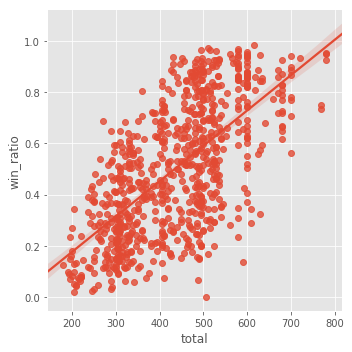

In [154]:
# todo move
# interpolation for no-fight-pokemon based on "total" attr
have_fight_pokemon_df = pokemon_fight_df.loc[pokemon_fight_df['win_ratio'] <= 1] # only pokemon that have fight
sns.lmplot(x='total', y='win_ratio', data=have_fight_pokemon_df) # to visualize data pattern

# create LinearRegression model for interpolation
linreg = LinearRegression()
linreg.fit(have_fight_pokemon_df['total'].values.reshape(-1, 1), have_fight_pokemon_df['win_ratio'].values.reshape(-1, 1))
no_fight_pokemon_df['win_ratio'] = linreg.predict(no_fight_pokemon_df['total'].values.reshape(-1, 1))

# check result
display(no_fight_pokemon_df)
display(pokemon_fight_df.loc[pokemon_fight_df['win_ratio'].isnull()])

x_train.shape (40000, 17)
x_test.shape (10000, 17)
y_train.shape (40000,)
y_test.shape (10000,)


C:\Python36-32\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


,is_first_win,diff_stat,first_hp,first_atk,first_def,first_sp.atk,first_sp.def,first_speed,first_total,first_win_ratio,second_hp,second_atk,second_def,second_sp.atk,second_sp.def,second_speed,second_total,second_win_ratio
0,0,-40,50,64,50,45,50,41,300,0.227273,70,70,40,60,40,60,340,0.424779
1,0,0,91,90,72,90,129,108,580,0.896000,91,129,90,72,90,108,580,0.853659
2,0,-80,55,40,85,80,105,40,405,0.236220,75,75,75,125,95,40,485,0.156716
3,0,-235,40,40,40,70,40,20,250,0.032520,77,120,90,60,90,48,485,0.278571
4,1,-10,70,60,125,115,70,55,495,0.355072,20,10,230,10,230,5,505,0.000000



----------------------------------------------------------------

visualize correlation between "win_ratio" and "other attributes"
we found that "speed" is seems to be a significant attribute
first_win_ratio    1.000000
first_speed        0.937646
first_total        0.649189
first_atk          0.502223
first_sp.atk       0.478143
first_sp.def       0.301649
first_hp           0.269427
first_def          0.106652
Name: first_win_ratio, dtype: float64


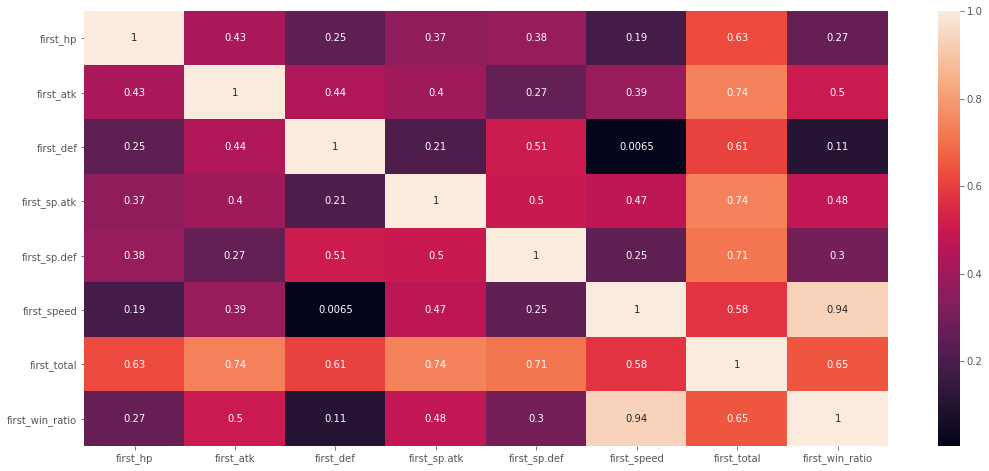

In [155]:
"""
3.1 Create train data
"""

train_df = combat_df.copy()
hp_dict = dict(zip(pokemon_fight_df['#'], pokemon_fight_df['hp']))
atk_dict = dict(zip(pokemon_fight_df['#'], pokemon_fight_df['atk']))
def_dict = dict(zip(pokemon_fight_df['#'], pokemon_fight_df['def']))
sp_atk_dict = dict(zip(pokemon_fight_df['#'], pokemon_fight_df['sp.atk']))
sp_def_dict = dict(zip(pokemon_fight_df['#'], pokemon_fight_df['sp.def']))
speed_dict = dict(zip(pokemon_fight_df['#'], pokemon_fight_df['speed']))
total_dict = dict(zip(pokemon_fight_df['#'], pokemon_fight_df['total']))
win_ratio_dict = dict(zip(pokemon_fight_df['#'], pokemon_fight_df['win_ratio']))

# create attrs
train_df['first_hp'] = train_df['first'].replace(hp_dict)
train_df['first_atk'] = train_df['first'].replace(atk_dict)
train_df['first_def'] = train_df['first'].replace(def_dict)
train_df['first_sp.atk'] = train_df['first'].replace(sp_atk_dict)
train_df['first_sp.def'] = train_df['first'].replace(sp_def_dict)
train_df['first_speed'] = train_df['first'].replace(speed_dict)
train_df['first_total'] = train_df['first'].replace(total_dict)
train_df['first_win_ratio'] = train_df['first'].replace(win_ratio_dict)
train_df['second_hp'] = train_df['second'].replace(hp_dict)
train_df['second_atk'] = train_df['second'].replace(atk_dict)
train_df['second_def'] = train_df['second'].replace(def_dict)
train_df['second_sp.atk'] = train_df['second'].replace(sp_atk_dict)
train_df['second_sp.def'] = train_df['second'].replace(sp_def_dict)
train_df['second_speed'] = train_df['second'].replace(speed_dict)
train_df['second_total'] = train_df['second'].replace(total_dict)
train_df['second_win_ratio'] = train_df['second'].replace(win_ratio_dict)

# create label
train_df['is_first_win'] = train_df.apply(lambda x: 1 if x['is_first_win'] == True else 0, axis=1)

# remove no need attrs
no_need_columns = ['first', 'second', 'winner', 'loser']
train_df = train_df.drop(no_need_columns, axis=1)

# split train & test data
y = train_df['is_first_win']
x = train_df.drop('is_first_win', axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=seed)

# create result
acc = {}

# display
print('x_train.shape', x_train.shape)
print('x_test.shape', x_test.shape)
print('y_train.shape', y_train.shape)
print('y_test.shape', y_test.shape)
display(train_df.head())
line()

print('visualize correlation between "win_ratio" and "other attributes"')
print('we found that "speed" is seems to be a significant attribute')
tmp_df = train_df.copy()
drop_columns = [c for c in tmp_df.columns if c.lower()[:6] == 'second'] + ['is_first_win', 'diff_stat']
tmp_df = tmp_df.drop(drop_columns, 1)
print(tmp_df.corr().sort_values(by='first_win_ratio', ascending=False)['first_win_ratio'])
plt.figure(figsize=(18, 8))
sns.heatmap(tmp_df.corr(), annot=True)
plt.show()

In [156]:
"""
3.2 Perform model & evaluation
"""

'\n3.2 Perform model & evaluation\n'

In [157]:
"""
model: LogisticRegression
"""

logreg = LogisticRegression()
logreg.fit(x_train, y_train)

name = 'LogisticRegression'
acc[name] = round(logreg.score(x_test, y_test) * 100, 2)
acc[name]

89.07

In [158]:
"""
model: kNN
"""

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train, y_train)

name = 'kNN'
acc[name] = round(knn.score(x_test, y_test) * 100, 2)
acc[name]

85.2

In [159]:
"""
model: GaussianNB
"""

gaussian = GaussianNB()
gaussian.fit(x_train, y_train)

name = 'GaussianNB'
acc[name] = round(gaussian.score(x_test, y_test) * 100, 2)
acc[name]

80.89

In [160]:
"""
model: Perceptron
"""

perceptron = Perceptron()
perceptron.fit(x_train, y_train)

name = 'Perceptron'
acc[name] = round(perceptron.score(x_test, y_test) * 100, 2)
acc[name]

C:\Python36-32\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


86.64

In [161]:
"""
model: DecisionTreeClassifier
"""

decision_tree = DecisionTreeClassifier()
decision_tree.fit(x_train, y_train)

name = 'DecisionTreeClassifier'
acc[name] = round(decision_tree.score(x_test, y_test) * 100, 2)
acc[name]

92.27

In [162]:
"""
model: RandomForestClassifier
"""

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(x_train, y_train)

name = 'RandomForestClassifier'
acc[name] = round(random_forest.score(x_test, y_test) * 100, 2)
acc[name]

94.49

In [163]:
"""
model: Ridge
"""

clf = Ridge(alpha=1.0)
clf.fit(x_train, y_train)

name = 'Ridge'
acc[name] = round(clf.score(x_test, y_test) * 100, 2)
acc[name]

51.4

In [164]:
"""
model: Lasso
"""

clf = Lasso(alpha=0.1)
clf.fit(x_train, y_train)

name = 'Lasso'
acc[name] = round(clf.score(x_test, y_test) * 100, 2)
acc[name]

46.99

In [165]:
"""
model: LinearDiscriminantAnalysis
"""

clf = LinearDiscriminantAnalysis()
clf.fit(x_train, y_train)

name = 'LinearDiscriminantAnalysis'
acc[name] = round(clf.score(x_test, y_test) * 100, 2)
acc[name]

C:\Python36-32\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


88.81

In [166]:
"""
3.3. Model summary
"""

# we got RandomForestClassifier as a winner
display(acc)

# but we want to know more about the importance features
acc_df = pd.DataFrame(list(acc.items()), columns=['name', 'acc'])
effective = pd.DataFrame()
effective['feature_name'] = x.columns.tolist()
effective['feature_importance'] = random_forest.feature_importances_
effective = effective.sort_values(by='feature_importance', ascending=False)
display(effective)

{'LogisticRegression': 89.07,
 'kNN': 85.2,
 'GaussianNB': 80.89,
 'Perceptron': 86.64,
 'DecisionTreeClassifier': 92.27,
 'RandomForestClassifier': 94.49,
 'Ridge': 51.4,
 'Lasso': 46.99,
 'LinearDiscriminantAnalysis': 88.81}

,feature_name,feature_importance
6,first_speed,0.188125
16,second_win_ratio,0.173400
14,second_speed,0.172128
8,first_win_ratio,0.171764
0,diff_stat,0.048093
7,first_total,0.032760
15,second_total,0.029603
10,second_atk,0.025082
2,first_atk,0.024398
12,second_sp.atk,0.018131
